# LUXE-NPOD Background Studies

Studies on kinematics distributions using LUXE signal samples.

We use two phase-0 samples:
- e0ppw_3.0_g4{0-4}
- e0ppw_7.0_g4{0-4}

Our reference page for LUXE signal MC samples is https://confluence.desy.de/display/LS/Signal+MC.

The notebook is base on uproot and pandas, and I am following the basic uproot documentation here: https://uproot.readthedocs.io/en/latest/basic.html

In [56]:
import numpy as np
import pandas as pd

In [57]:
import uproot

Our signal samples are stored at KIT in Torben's /ceph directory: 
`/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw`

In [58]:
!ls /ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw

e0ppw_3_0_0_particles_g4.root  e0ppw_7_0_0_particles_g4.root
e0ppw_3_0_1_particles_g4.root  e0ppw_7_0_1_particles_g4.root
e0ppw_3_0_2_particles_g4.root  e0ppw_7_0_2_particles_g4.root
e0ppw_3_0_3_particles_g4.root  e0ppw_7_0_3_particles_g4.root


In [59]:
# For now, open just one file
#phase0_folder = "/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw/"

#file_3_0 = uproot.open(phase0_folder + "e0ppw_3_0_0_particles_g4.root")

#file_3_0

In [60]:
#file_3_0["Tracks"]

We are interested in the `Tracks` TTree

In [61]:
# Get access to the 'Tracks' TTree 
#Tracks = uproot.open(phase0_folder + "e0ppw_3_0_0_particles_g4.root:Tracks")

In [62]:
# Show branches in "Tracks"
#Tracks.keys()

In [63]:
# Defining data frame from Tracks tree with the interesting variables
#df = Tracks.arrays(["E", "pdg","detid","weight","theta","phi","vtxx","vtxy","vtxz","px","py","pz","x","y","z"], library="pd")

We have more than one set of files, depending on the phase we want to study and the laser properties. 

We define a set of dictionaries, one for each possbility. This will make the code more 'automatic' in understanding what files it has to read, where to store the output, etc.

In [64]:
from collections import OrderedDict

# Define variables 
variablesDic = {}

# Phase0, xi = 3.0 
variablesDic['phase0_e0ppw_3_0'] = {
    'output_folder' : 'e0ppw_3_0',
    'opening_list'  : [
        "/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw/e0ppw_3_0_0_particles_g4.root:Tracks",
        "/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw/e0ppw_3_0_1_particles_g4.root:Tracks",
        "/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw/e0ppw_3_0_2_particles_g4.root:Tracks",
        "/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw/e0ppw_3_0_3_particles_g4.root:Tracks",
    ],
    'BX'            : 4,
}

# Phase0, xi = 7.0
variablesDic['phase0_e0ppw_7_0'] = {
    'output_folder' : 'e0ppw_7_0',
    'opening_list'  : [
        "/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw/e0ppw_7_0_0_particles_g4.root:Tracks",
        "/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw/e0ppw_7_0_1_particles_g4.root:Tracks",
        "/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw/e0ppw_7_0_2_particles_g4.root:Tracks",
        "/ceph/ferber/LUXE/ptarmigan-v0.8.1/e-laser/phase0/ppw/e0ppw_7_0_3_particles_g4.root:Tracks",
    ],
    'BX'            : 4,
}

In [136]:
# Define the phase and laser properties to study. Call it 'era'
era = 'phase0_e0ppw_3_0'

# These are our global variables
opening_list  = variablesDic[era]['opening_list']
output_folder = variablesDic[era]['output_folder'] 
BX            = variablesDic[era]['BX']

# The energy cut does not depend on the phase, but on the detector: it is always the same.
# Since we cannot detect particles with energy below 'energy_cut' in any case, should we
# already cut them when we load the files?
energy_cut = 0.5 # GeV

Read all the files at the same time. To reduce the memory needed, we load them one by one, selecting only events with the correct detid. We then concatenate the data frames associated to each file.

In [206]:
# df=pd.DataFrame()º
Tracks = uproot.open(opening_list[0])
df_tmp = Tracks.arrays(["E", "pdg","detid","weight","theta","phi","vtxx","vtxy","vtxz","px","py","pz","x","y","z"], library="pd")
df_bsm = df_tmp[(df_tmp["detid"]==9000) & (df_tmp["E"]>energy_cut)]
df_bsm.head(10)

for i in range(1, len(opening_list)):
    Tracks = uproot.open(opening_list[i])
    df_tmp = Tracks.arrays(["E", "pdg","detid","weight","theta","phi","vtxx","vtxy","vtxz","px","py","pz","x","y","z"], library="pd")
    df_tmp_bsm = df_tmp[(df_tmp["detid"]==9000) & (df_tmp["E"]>energy_cut)]
    df_bsm.append(df_tmp_bsm)

## Background studies

We want to check which events produces signatures that can mimic our signal:
- two neutrons
- two photons
- one neutron and one photon

To do so, we look at what hits our BSM calorimeter (for the moment, just a dummy volume).

We identify tracks reaching the BSM calorimeter by requiring `detid` = 9000.

In [207]:
df_bsm.head(10)

,,E,pdg,detid,weight,theta,phi,vtxx,vtxy,vtxz,px,py,pz,x,y,z
entry,subentry,,,,,,,,,,,,,,,
384720,10,1.011737,13,9000,1500.0,0.420707,2.307819,-31.703290,38.659746,13917.047758,-0.305333,0.336402,1.015389,-631.916905,711.654873,16000.0
690917,5,1.628003,2112,9000,1500.0,0.205431,-1.180054,0.493547,-0.178720,13820.998857,0.185649,-0.450688,2.339239,159.786333,-403.955500,16000.0
913686,9,1.385779,2112,9000,1500.0,0.214906,-2.682444,-0.447670,0.068385,13842.283626,-0.406629,-0.201033,2.078144,-428.905942,-195.724962,16000.0


### Two neutron case
We start by looking at events with two neutrons. We select neutrons using the `pdg` variable, that for neutrons is `2112`.

In [143]:
# Select events with exactly two neutrons
def get_sum(df_bsm):
    """Returns sum of 'pdg' values in each event"""
    return sum(df_bsm['pdg'])

def is_neutron(df_bsm):
    """Returns number of neutrons in each event"""
    return sum(df_bsm['pdg'] == 2112)


# We create a pandas series on the 'entry' index. It is a boolean series telling if each event has EXACTLY two neutrons
list_nn = df_bsm.groupby('entry').apply(get_sum)==4224

# We create a pandas series on the 'entry' index. It is a boolean series telling if each event has AT LEAST two neutrons
list_multi_n = df_bsm.groupby('entry').apply(is_neutron) > 1

In [144]:
# We convert the series into a 'mask' that we use to filter the dataframe
# mask_nn = list_nn[list_nn==True].index # Exactly and only two neutrons in the event
mask_nn = list_multi_n[list_multi_n==True].index # At least two neutrons in the event

In [145]:
# Here we filter
df_bsm_nn = df_bsm.loc[mask_nn]
df_bsm_nn.head(10)

E   pdg  detid  weight     theta       phi  \
entry subentry                                                          
84    5         1.972340e-04  2112   9000  1500.0  0.312968 -0.994069   
      6         1.035873e-04  2112   9000  1500.0  0.563941 -1.829657   
243   41        4.525873e-12  2112   9000  1500.0  0.340498 -2.843154   
      46        3.770494e-09  2112   9000  1500.0  0.553394  0.198595   
1296  15        1.822510e-07  2112   9000  1500.0  0.148220 -1.801857   
      19        7.117354e-07  2112   9000  1500.0  0.663408 -1.875098   
      43        8.110585e-04    12   9000  1500.0  0.069855  2.108546   
1634  8         1.700025e-10  2112   9000  1500.0  0.975914  3.056311   
      14        7.355565e-09  2112   9000  1500.0  0.697667  0.002343   
2051  7         1.160224e-08  2112   9000  1500.0  0.214209 -2.897164   

                      vtxx        vtxy         vtxz            px  \
entry subentry                                                      
84    5         118.895719  111.979832  9077.613133  3.232220e-03   
      6         118.895719  111.979832  9077.613133 -1.909034e-03   
243   41       -377.167640 -191.355322  7230.406714 -9.308626e-07   
      46        -99.804831 -102.362194  7560.556186  4.337042e-05   
1296  15       -113.562280   23.854150  7319.019839 -1.979173e-05   
      19        -67.999689  118.720991  7567.776101 -2.133847e-04   
      43        124.428559   28.903444  7303.431618 -2.899591e-05   
1634  8         166.137820  135.027414  7166.761076 -1.474918e-05   
      14       -139.846326   12.259285  7306.878608  7.552876e-05   
2051  7        -124.509289    0.170595  7307.254708 -3.045487e-05   

                          py        pz           x           y        z  
entry subentry                                                           
84    5        -4.968815e-03  0.018318  462.739071  473.245123  16000.0  
      6        -7.209289e-03  0.011792  447.515809 -604.981044  16000.0  
243   41       -2.863577e-07  0.000003 -243.495758  697.114095  16000.0  
      46        8.728201e-06  0.000072  533.861470  263.298398  16000.0  
1296  15       -8.412600e-05  0.000579  489.636981  743.180737  16000.0  
      19       -6.794471e-04  0.000911  919.176868  572.524294  16000.0  
      43        4.862029e-05  0.000809 -187.239989  551.508678  16000.0  
1634  8         1.260889e-06  0.000010  210.586315 -170.684018  16000.0  
      14        1.769993e-07  0.000090  180.426352   94.811879  16000.0  
2051  7        -7.595934e-06  0.000144   27.527511  768.863292  16000.0

Now that we selected events with at least two neutrons, we want to order, in each event, the particles by their energy, and keep events in which the *two most energetic* particles are neutrons. 

In [146]:
# Sort by particle Energy
df_bsm_nn_sort = df_bsm_nn.groupby('entry').apply(lambda x: x.sort_values(['E'], ascending=False))
df_bsm_nn_sort.head(20)

E   pdg  detid  weight     theta       phi  \
entry entry subentry                                                          
84    84    5         1.972340e-04  2112   9000  1500.0  0.312968 -0.994069   
            6         1.035873e-04  2112   9000  1500.0  0.563941 -1.829657   
243   243   46        3.770494e-09  2112   9000  1500.0  0.553394  0.198595   
            41        4.525873e-12  2112   9000  1500.0  0.340498 -2.843154   
1296  1296  43        8.110585e-04    12   9000  1500.0  0.069855  2.108546   
            19        7.117354e-07  2112   9000  1500.0  0.663408 -1.875098   
            15        1.822510e-07  2112   9000  1500.0  0.148220 -1.801857   
1634  1634  14        7.355565e-09  2112   9000  1500.0  0.697667  0.002343   
            8         1.700025e-10  2112   9000  1500.0  0.975914  3.056311   
2051  2051  13        5.109989e-04    22   9000  1500.0  0.895419  1.355936   
            8         4.180704e-04    12   9000  1500.0  2.392712 -2.143068   
            7         1.160224e-08  2112   9000  1500.0  0.214209 -2.897164   
            12        8.929646e-12  2112   9000  1500.0  0.530203  0.041458   
2080  2080  7         9.746076e-09  2112   9000  1500.0  1.626553 -0.241781   
            8         8.180129e-09  2112   9000  1500.0  1.876906  0.808686   
3035  3035  9         1.666059e-03    12   9000  1500.0  0.324645 -2.911048   
            7         8.809202e-07  2112   9000  1500.0  1.171663 -1.551364   
            8         6.450555e-07  2112   9000  1500.0  0.867866  2.303987   
4023  4023  15        4.684969e-07  2112   9000  1500.0  2.939124 -0.088019   
            11        7.404360e-09  2112   9000  1500.0  1.029750 -0.282214   

                             vtxx         vtxy          vtxz            px  \
entry entry subentry                                                         
84    84    5          118.895719   111.979832   9077.613133  3.232220e-03   
            6          118.895719   111.979832   9077.613133 -1.909034e-03   
243   243   46         -99.804831  -102.362194   7560.556186  4.337042e-05   
            41        -377.167640  -191.355322   7230.406714 -9.308626e-07   
1296  1296  43         124.428559    28.903444   7303.431618 -2.899591e-05   
            19         -67.999689   118.720991   7567.776101 -2.133847e-04   
            15        -113.562280    23.854150   7319.019839 -1.979173e-05   
1634  1634  14        -139.846326    12.259285   7306.878608  7.552876e-05   
            8          166.137820   135.027414   7166.761076 -1.474918e-05   
2051  2051  13        -128.964654    38.616957  15722.327104  8.503288e-05   
            8          278.357822  2062.727657  17938.133135 -1.541396e-04   
            7         -124.509289     0.170595   7307.254708 -3.045487e-05   
            12         -90.698525    61.551155   7289.195377  2.069774e-06   
2080  2080  7        -3718.593506  1833.679412  11646.002166  1.311893e-04   
            8        -3718.593506  1833.679412  11646.002166  8.162392e-05   
3035  3035  9          265.171611    68.562961  13941.572070 -5.173657e-04   
            7          -86.618419   -27.114798   7332.769155  2.303559e-05   
            8          -86.618419   -27.114798   7332.769155 -5.621577e-04   
4023  4023  15       -3718.397366  1034.714652  10840.414328  1.879461e-04   
            11         -30.356017    31.082494   7278.612306  9.710917e-05   

                                py        pz            x           y  \
entry entry subentry                                                    
84    84    5        -4.968815e-03  0.018318   462.739071  473.245123   
            6        -7.209289e-03  0.011792   447.515809 -604.981044   
243   243   46        8.728201e-06  0.000072   533.861470  263.298398   
            41       -2.863577e-07  0.000003  -243.495758  697.114095   
1296  1296  43        4.862029e-05  0.000809  -187.239989  551.508678   
            19       -6.794471e-04  0.000911   919.176868  572.524

In [147]:
# Leading particle is a neutron
neutron_mask_0 = df_bsm_nn_sort.groupby('entry').nth(0)['pdg'] == 2112
print(neutron_mask_0[:10])

# Sub-leading particle is a neutron
neutron_mask_1 = df_bsm_nn_sort.groupby('entry').nth(1)['pdg'] == 2112
print(neutron_mask_1[:10])

neutron_mask = neutron_mask_0 & neutron_mask_1
print(neutron_mask.loc[1296])

entry
84       True
243      True
1296    False
1634     True
2051    False
2080     True
3035    False
4023     True
4045     True
4190     True
Name: pdg, dtype: bool
entry
84       True
243      True
1296     True
1634     True
2051    False
2080     True
3035     True
4023     True
4045     True
4190     True
Name: pdg, dtype: bool
False


In [148]:
print(neutron_mask[0:10])

# Two leading particles are neutrons
mask_two_n = neutron_mask[neutron_mask==True].index 

entry
84       True
243      True
1296    False
1634     True
2051    False
2080     True
3035    False
4023     True
4045     True
4190     True
Name: pdg, dtype: bool


In [149]:
# Apply mask to have only events in which two leading particles are neutrons
df_bsm_two_n = df_bsm_nn_sort.loc[mask_two_n]
df_bsm_two_n.head(20)

E   pdg  detid  weight     theta       phi  \
entry entry subentry                                                          
84    84    5         1.972340e-04  2112   9000  1500.0  0.312968 -0.994069   
            6         1.035873e-04  2112   9000  1500.0  0.563941 -1.829657   
243   243   46        3.770494e-09  2112   9000  1500.0  0.553394  0.198595   
            41        4.525873e-12  2112   9000  1500.0  0.340498 -2.843154   
1634  1634  14        7.355565e-09  2112   9000  1500.0  0.697667  0.002343   
            8         1.700025e-10  2112   9000  1500.0  0.975914  3.056311   
2080  2080  7         9.746076e-09  2112   9000  1500.0  1.626553 -0.241781   
            8         8.180129e-09  2112   9000  1500.0  1.876906  0.808686   
4023  4023  15        4.684969e-07  2112   9000  1500.0  2.939124 -0.088019   
            11        7.404360e-09  2112   9000  1500.0  1.029750 -0.282214   
4045  4045  7         7.841376e-10  2112   9000  1500.0  1.394355 -0.711791   
            8         5.241710e-10  2112   9000  1500.0  0.779175 -0.501105   
            9         4.641560e-10  2112   9000  1500.0  0.368203  1.009752   
4190  4190  20        6.216308e-06  2112   9000  1500.0  2.496369 -0.319207   
            7         2.853392e-11  2112   9000  1500.0  0.817390  2.324989   
4604  4604  8         7.941958e-11  2112   9000  1500.0  0.557076  1.195479   
            7         4.247215e-11  2112   9000  1500.0  1.548325  1.776626   
5610  5610  9         1.169258e-09  2112   9000  1500.0  2.940761  0.185605   
            8         3.586592e-12  2112   9000  1500.0  2.411399 -0.216188   
5709  5709  7         3.329197e-07  2112   9000  1500.0  0.666787 -1.396317   

                             vtxx         vtxy          vtxz            px  \
entry entry subentry                                                         
84    84    5          118.895719   111.979832   9077.613133  3.232220e-03   
            6          118.895719   111.979832   9077.613133 -1.909034e-03   
243   243   46         -99.804831  -102.362194   7560.556186  4.337042e-05   
            41        -377.167640  -191.355322   7230.406714 -9.308626e-07   
1634  1634  14        -139.846326    12.259285   7306.878608  7.552876e-05   
            8          166.137820   135.027414   7166.761076 -1.474918e-05   
2080  2080  7        -3718.593506  1833.679412  11646.002166  1.311893e-04   
            8        -3718.593506  1833.679412  11646.002166  8.162392e-05   
4023  4023  15       -3718.397366  1034.714652  10840.414328  1.879461e-04   
            11         -30.356017    31.082494   7278.612306  9.710917e-05   
4045  4045  7         -238.787948     4.236698   7337.424959  2.861447e-05   
            8         -238.787948     4.236698   7337.424959  1.934220e-05   
            9         -238.787948     4.236698   7337.424959  5.655993e-06   
4190  4190  20         -24.175683    57.556124   7405.127570  1.951553e-03   
            7          -85.269092   -24.211093   7295.076788 -3.656819e-06   
4604  4604  8         -129.507858     0.520967   7339.529855  2.367616e-06   
            7         -129.507858     0.520967   7339.529855 -1.825398e-06   
5610  5610  9         -105.911122    53.675955   7371.771961  9.190072e-06   
            8         -136.291251    -2.264793   7354.902846  1.691318e-06   
5709  5709  7         -130.428499   -16.351257   7360.820300  8.491828e-05   

                                py            pz            x            y  \
entry entry subentry                                                         
84    84    5        -4.968815e-03  1.831751e-02   462.739071   473.245123   
            6        -7.209289e-03  1.179180e-02   447.515809  -604.981044   
243   243   46        8.728201e-06  7.161059e-05   533.861470   263.298398   
            41       -2.863577e-07  2.748854e-06  -243.495758   697.114095   
1634  1634  14        1.769993e-07  9.009686e-05   180.426352    94.811879   
            8         1.260889e

In [159]:
# Two leading particle in the event are neutrons
df_bsm_two_n.iloc[0:2]

E   pdg  detid  weight     theta       phi  \
entry entry subentry                                                      
84    84    5         0.000197  2112   9000  1500.0  0.312968 -0.994069   
            6         0.000104  2112   9000  1500.0  0.563941 -1.829657   

                            vtxx        vtxy         vtxz        px        py  \
entry entry subentry                                                            
84    84    5         118.895719  111.979832  9077.613133  0.003232 -0.004969   
            6         118.895719  111.979832  9077.613133 -0.001909 -0.007209   

                            pz           x           y        z  
entry entry subentry                                             
84    84    5         0.018318  462.739071  473.245123  16000.0  
            6         0.011792  447.515809 -604.981044  16000.0

Now we build some interesting kinematic variables, per event.

In [151]:
df_nn_kinematics = pd.DataFrame()

In [152]:
# Delta phi 
def delta_phi(df_nn_kinematics):
    d_phi = df_nn_kinematics['phi_1'] - df_nn_kinematics['phi_2']    
    if d_phi >= np.pi: d_phi = d_phi - 2*np.pi
    if d_phi < -np.pi: d_phi = d_phi + 2*np.pi
    return d_phi


# Copying TLorentzVector definition https://root.cern.ch/doc/master/TLorentzVector_8h_source.html#l00498
def inv_mass(E_1, px_1, py_1, pz_1,
             E_2, px_2, py_2, pz_2):
    return np.sqrt( np.absolute((E_1+E_2)**2 - (px_1+px_2)**2 - (py_1+py_2)**2 - (pz_1+pz_2)**2) )
    

In [153]:
# Dirty trick to have the first and second particles: create two separate dataframes
# with the first and second subentry
df_bsm_nn_first  = df_bsm_two_n.groupby('entry').nth(0)
df_bsm_nn_second = df_bsm_two_n.groupby('entry').nth(1)

In [154]:
# Event variables
df_nn_kinematics["weight"] = df_bsm_nn_first["weight"]

# Build first particle
df_nn_kinematics["E_1"] = df_bsm_nn_first["E"]
df_nn_kinematics["m_1"] = 0.939565
df_nn_kinematics["eta_1"] = -np.log(np.tan(0.5*df_bsm_nn_first["theta"]))
df_nn_kinematics["theta_1"] = df_bsm_nn_first["theta"]
df_nn_kinematics["phi_1"] = df_bsm_nn_first["phi"]
df_nn_kinematics["vtxx_1"] = df_bsm_nn_first["vtxx"]
df_nn_kinematics["vtxy_1"] = df_bsm_nn_first["vtxy"]
df_nn_kinematics["vtxz_1"] = df_bsm_nn_first["vtxz"]
df_nn_kinematics["px_1"] = df_bsm_nn_first["px"]
df_nn_kinematics["py_1"] = df_bsm_nn_first["py"]
df_nn_kinematics["pz_1"] = df_bsm_nn_first["pz"]
df_nn_kinematics["x_1"] = df_bsm_nn_first["x"]
df_nn_kinematics["y_1"] = df_bsm_nn_first["y"]
df_nn_kinematics["z_1"] = df_bsm_nn_first["z"]

# Build second particle
df_nn_kinematics["E_2"] = df_bsm_nn_second["E"]
df_nn_kinematics["m_2"] = 0.939565
df_nn_kinematics["eta_2"] = -np.log(np.tan(0.5*df_bsm_nn_second["theta"]))
df_nn_kinematics["theta_2"] = df_bsm_nn_second["theta"]
df_nn_kinematics["phi_2"] = df_bsm_nn_second["phi"]
df_nn_kinematics["vtxx_2"] = df_bsm_nn_second["vtxx"]
df_nn_kinematics["vtxy_2"] = df_bsm_nn_second["vtxy"]
df_nn_kinematics["vtxz_2"] = df_bsm_nn_second["vtxz"]
df_nn_kinematics["px_2"] = df_bsm_nn_second["px"]
df_nn_kinematics["py_2"] = df_bsm_nn_second["py"]
df_nn_kinematics["pz_2"] = df_bsm_nn_second["pz"]
df_nn_kinematics["x_2"] = df_bsm_nn_second["x"]
df_nn_kinematics["y_2"] = df_bsm_nn_second["y"]
df_nn_kinematics["z_2"] = df_bsm_nn_second["z"]


In [155]:
df_nn_kinematics["m_nn"] = inv_mass(df_nn_kinematics["E_1"], df_nn_kinematics["m_1"], df_nn_kinematics["eta_1"], df_nn_kinematics["phi_1"],
                                    df_nn_kinematics["E_2"], df_nn_kinematics["m_2"], df_nn_kinematics["eta_2"], df_nn_kinematics["phi_2"])

In [156]:
# particle distance from the center of the detector
df_nn_kinematics["r_1"] = np.sqrt(df_nn_kinematics["x_1"]**2 + df_nn_kinematics["y_1"]**2)
df_nn_kinematics["r_2"] = np.sqrt(df_nn_kinematics["x_2"]**2 + df_nn_kinematics["y_2"]**2)

# Distance between the two particles at the detector surface
df_nn_kinematics["dist_n1_n2"] = np.sqrt( (df_nn_kinematics["x_2"] - df_nn_kinematics["x_1"])**2 + (df_nn_kinematics["y_1"] - df_nn_kinematics["y_2"])**2)


In [158]:
# Delta_phi between neutrons
df_nn_kinematics["delta_phi"] = df_nn_kinematics.apply(delta_phi, axis = 1)
df_nn_kinematics[['phi_1','phi_2','delta_phi','E_1','E_2']].head(10)


,phi_1,phi_2,delta_phi,E_1,E_2
entry,,,,,
84,-0.994069,-1.829657,0.835588,1.972340e-04,1.035873e-04
243,0.198595,-2.843154,3.041749,3.770494e-09,4.525873e-12
1634,0.002343,3.056311,-3.053968,7.355565e-09,1.700025e-10
2080,-0.241781,0.808686,-1.050466,9.746076e-09,8.180129e-09
4023,-0.088019,-0.282214,0.194195,4.684969e-07,7.404360e-09
4045,-0.711791,-0.501105,-0.210687,7.841376e-10,5.241710e-10
4190,-0.319207,2.324989,-2.644196,6.216308e-06,2.853392e-11
4604,1.195479,1.776626,-0.581147,7.941958e-11,4.247215e-11
5610,0.185605,-0.216188,0.401793,1.169258e-09,3.586592e-12


In [160]:
# Having a look at the dataframe
df_nn_kinematics.head(5)

df_nn_kinematics[df_nn_kinematics['E_2'] > 0.5][['E_1','E_2']].head(10)

,E_1,E_2
entry,,


Now, finally plotting. We define a function for that, and then we plot few distributions.

In [84]:
import matplotlib.pyplot as plt
import sys,os

def plot_histo(df, variable, weight=1, bins=10, title="", x_label="", y_label="", file_name=None, folder_name=None, file_format="png"):
    """Plots distributions from a dataframe

    df: input dataframe
    variable: distribution to plot
    title: appears on top of the plot
    weight: weight to apply to the histogram
    x_label: label of x-axis
    y_label: label of y-axis
    file_name: if not empty, name of file where plot is printed
    folder_name: if not empty, name of directory where plot is printed
    file_format: if file_name not empty, format of output file
    """

    # Prepare histogram
    # df[variable].plot(kind='hist', weights=weight)
    plt.hist(df[variable], bins=bins)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Preparing output
    if file_name:
        output_name = file_name + "." + file_format
        if folder_name:
            command = "mkdir -p {}".format(folder_name)
            os.system(command)
            output_name = folder_name + "/" + file_name + "." + file_format
        plt.savefig(output_name)

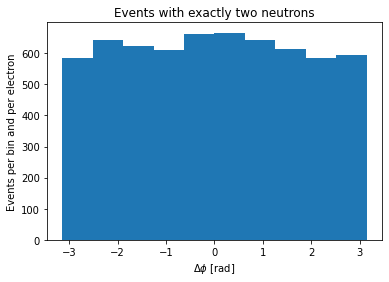

In [85]:
# Delta-phi(n,n)
plot_histo(df_nn_kinematics, 'delta_phi', 
           weight      = df_nn_kinematics['weight']/(BX*1.5e9),
           bins        = 10,
           title       = "Events with exactly two neutrons", 
           x_label     = r"$\Delta \phi$ [rad]", 
           y_label     = "Events per bin and per electron",
           file_name   = "delta_phi_nn",
           folder_name = output_folder)

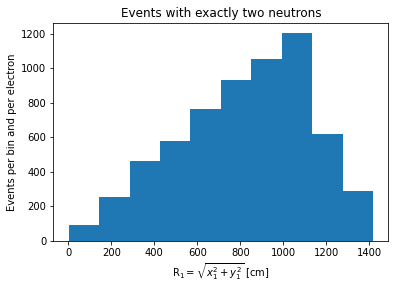

In [86]:
# r_1: distance of first neutron from the center of the detector
plot_histo(df_nn_kinematics, 'r_1', 
           weight      = df_nn_kinematics['weight']/(BX*1.5e9), 
           bins        = 10,
           title       = "Events with exactly two neutrons", 
           x_label     = "R$_1 = \sqrt{x_1^2 + y_1^2}$ [cm]", 
           y_label     = "Events per bin and per electron",
           file_name   = "r_1_nn",
           folder_name = output_folder)

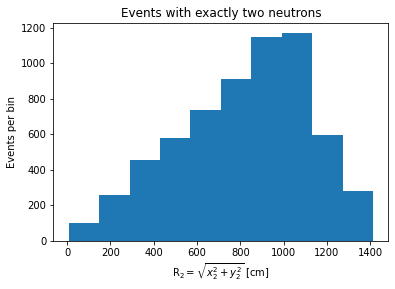

In [87]:
# r_2: distance of second neutron from the center of the detector
plot_histo(df_nn_kinematics, 'r_2', 
           weight      = df_nn_kinematics['weight']/(BX*1.5e9), 
           bins        = 10,
           title       = "Events with exactly two neutrons", 
           x_label     = "R$_2 = \sqrt{x_2^2 + y_2^2}$ [cm]", 
           y_label     = "Events per bin",
           file_name   = "r_2_nn",
           folder_name = output_folder)

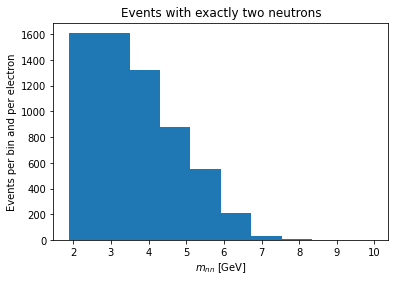

In [88]:
# m_nn: invariant mass of the two neutrons system
plot_histo(df_nn_kinematics, 'm_nn', 
           weight      = df_nn_kinematics['weight']/(BX*1.5e9), 
           bins        = 10,
           title       = "Events with exactly two neutrons", 
           x_label     = "$m_{nn}$ [GeV]",
           y_label     = "Events per bin and per electron",
           file_name   = "m_nn",
           folder_name = output_folder)

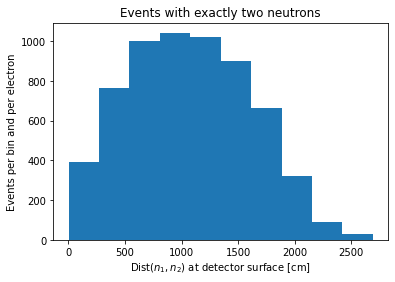

In [89]:
# dist_n1_n2: distance between the two neutrons at the detector surface
plot_histo(df_nn_kinematics, 'dist_n1_n2', 
           weight      = df_nn_kinematics['weight']/(BX*1.5e9), 
           bins        = 10,
           title       = "Events with exactly two neutrons", 
           x_label     = "Dist($n_1,n_2$) at detector surface [cm]",
           y_label     = "Events per bin and per electron",
           file_name   = "dist_n1_n2",
           folder_name = output_folder)

### Two photons case
We move to events with two photons. We select photons using the `pdg` variable, that for photons is `22`.

In the code, we will use the 'y' letter instead of '$\gamma$'.

In [161]:
# Select events with exactly two photons
def get_sum(df_bsm):
    """Returns sum of 'pdg' values in each event"""
    return sum(df_bsm['pdg'])

def is_photon(df_bsm):
    """Returns number of photons in each event"""
    return sum(df_bsm['pdg'] == 22)


# We create a pandas series on the 'entry' index. It is a boolean series telling if each event has EXACTLY two photons
list_yy = df_bsm.groupby('entry').apply(get_sum)==44

# We create a pandas series on the 'entry' index. It is a boolean series telling if each event has AT LEAST two photons
list_multi_y = df_bsm.groupby('entry').apply(is_photon) > 1

In [162]:
# We convert the series into a 'mask' that we use to filter the dataframe
mask_yy = list_multi_y[list_multi_y==True].index # At least two neutrons in the event

In [163]:
# Here we filter
df_bsm_yy = df_bsm.loc[mask_yy]
df_bsm_yy.head(15)

E   pdg  detid  weight     theta       phi  \
entry subentry                                                          
1126  7         6.412902e-04    22   9000  1500.0  0.960666 -0.114437   
      8         6.135861e-05    22   9000  1500.0  0.580854  2.718520   
1597  5         1.972647e-03    22   9000  1500.0  0.563703 -0.604586   
      6         1.577969e-03    22   9000  1500.0  0.647599  2.304444   
3861  5         1.795109e-03    22   9000  1500.0  0.462408  1.145082   
      6         9.056253e-04    22   9000  1500.0  0.790768 -2.552529   
5131  11        3.715960e-07  2112   9000  1500.0  2.061637 -0.206468   
      17        3.324222e-08  2112   9000  1500.0  0.321238 -1.278460   
      20        4.933997e-03    22   9000  1500.0  0.718025 -1.692277   
      21        1.475016e-10  2112   9000  1500.0  0.494611  1.573943   
      36        1.900859e-03    22   9000  1500.0  0.260258  1.466448   
      40        6.392952e-11  2112   9000  1500.0  2.700959  1.916259   
6254  21        1.360893e-03   -12   9000  1500.0  0.557665  2.264579   
      22        1.867585e-08  2112   9000  1500.0  1.604919  1.427442   
      23        4.933999e-03    22   9000  1500.0  2.123001  1.313085   

                       vtxx         vtxy          vtxz            px  \
entry subentry                                                         
1126  7        -3515.148252   443.968686  13201.885397  5.221468e-04   
      8        -3515.148252   443.968686  13201.885397 -3.070122e-05   
1597  5         -182.614682   -99.508363  14625.009226  8.671855e-04   
      6         -182.614682   -99.508363  14625.009226 -6.374072e-04   
3861  5          272.543250   106.057305  14158.231744  3.307099e-04   
      6         2369.088837   845.651180  13335.998979 -5.352975e-04   
5131  11        -180.580973   -16.902046   7398.510418  7.213206e-04   
      17        -301.418184    43.572156   7722.587935  2.274229e-05   
      20          47.212246  1969.418933  13553.367436 -3.933663e-04   
      21         -46.341625  -116.282011   7480.421654 -2.486800e-08   
      36         253.115394   157.475948  13927.876651  5.094900e-05   
      40         152.766647   -50.290576   7264.966099 -1.583029e-06   
6254  21        1891.795848 -1978.441257   9915.578559 -4.605274e-04   
      22        -183.577143   -65.873476   7653.717865  2.674781e-05   
      23         317.457782 -2513.898853  17068.167856  1.070615e-03   

                      py        pz            x            y             z  
entry subentry                                                              
1126  7        -0.000060  0.000367   128.049679   -72.678258  16000.000000  
      8         0.000014  0.000051  1002.500000  -977.041924  16073.904702  
1597  5        -0.000599  0.001667   532.475213  -593.556681  16000.000000  
      6         0.000707  0.001258  -879.030448   672.993137  16000.000000  
3861  5         0.000729  0.001607   651.664156   942.150258  16000.000000  
      6        -0.000358  0.000637    -2.980654  -566.614039  16000.000000  
5131  11       -0.000151 -0.000394   -71.060004   772.348368  16178.060000  
      17       -0.000076  0.000237   575.513890  -485.817954  16000.000000  
      20       -0.003222  0.003716  -211.794218  -152.158159  16000.000000  
      21        0.000008  0.000015  -672.670516  -225.733045  16000.000000  
      36        0.000486  0.001837   310.590371   706.275828  16000.000000  
      40        0.000004 -0.000010    76.015957  -749.243937  16178.060000  
6254  21        0.000554  0.001155  -534.827904   939.174044  16000.000000  
      22        0.000185 -0.000006   795.555619 -1002.500000  16100.591204  
      23        0.004062 -0.002588   715.821334 -1002.500000  16105.126005

As we did in the two-neutron case, now that we selected events with at least two photons, we want to order, in each event, the particles by their energy, and keep events in which the two most energetic particles are photons.

In [164]:
# Sort by particle Energy
df_bsm_yy_sort = df_bsm_yy.groupby('entry').apply(lambda x: x.sort_values(['E'], ascending=False))
df_bsm_yy_sort.head(20)

E   pdg  detid  weight     theta       phi  \
entry entry subentry                                                          
1126  1126  7         6.412902e-04    22   9000  1500.0  0.960666 -0.114437   
            8         6.135861e-05    22   9000  1500.0  0.580854  2.718520   
1597  1597  5         1.972647e-03    22   9000  1500.0  0.563703 -0.604586   
            6         1.577969e-03    22   9000  1500.0  0.647599  2.304444   
3861  3861  5         1.795109e-03    22   9000  1500.0  0.462408  1.145082   
            6         9.056253e-04    22   9000  1500.0  0.790768 -2.552529   
5131  5131  20        4.933997e-03    22   9000  1500.0  0.718025 -1.692277   
            36        1.900859e-03    22   9000  1500.0  0.260258  1.466448   
            11        3.715960e-07  2112   9000  1500.0  2.061637 -0.206468   
            17        3.324222e-08  2112   9000  1500.0  0.321238 -1.278460   
            21        1.475016e-10  2112   9000  1500.0  0.494611  1.573943   
            40        6.392952e-11  2112   9000  1500.0  2.700959  1.916259   
6254  6254  23        4.933999e-03    22   9000  1500.0  2.123001  1.313085   
            26        2.223934e-03   -12   9000  1500.0  0.160760 -0.937067   
            21        1.360893e-03   -12   9000  1500.0  0.557665  2.264579   
            32        9.238292e-04    22   9000  1500.0  0.425028 -0.407422   
            38        2.519891e-05   -12   9000  1500.0  2.485247 -2.714657   
            48        5.958575e-08  2112   9000  1500.0  2.632017 -2.454242   
            22        1.867585e-08  2112   9000  1500.0  1.604919  1.427442   
            37        1.047532e-08  2112   9000  1500.0  2.099618 -0.396903   

                             vtxx         vtxy          vtxz            px  \
entry entry subentry                                                         
1126  1126  7        -3515.148252   443.968686  13201.885397  5.221468e-04   
            8        -3515.148252   443.968686  13201.885397 -3.070122e-05   
1597  1597  5         -182.614682   -99.508363  14625.009226  8.671855e-04   
            6         -182.614682   -99.508363  14625.009226 -6.374072e-04   
3861  3861  5          272.543250   106.057305  14158.231744  3.307099e-04   
            6         2369.088837   845.651180  13335.998979 -5.352975e-04   
5131  5131  20          47.212246  1969.418933  13553.367436 -3.933663e-04   
            36         253.115394   157.475948  13927.876651  5.094900e-05   
            11        -180.580973   -16.902046   7398.510418  7.213206e-04   
            17        -301.418184    43.572156   7722.587935  2.274229e-05   
            21         -46.341625  -116.282011   7480.421654 -2.486800e-08   
            40         152.766647   -50.290576   7264.966099 -1.583029e-06   
6254  6254  23         317.457782 -2513.898853  17068.167856  1.070615e-03   
            26        -313.619296   299.552820   7698.134011  2.107957e-04   
            21        1891.795848 -1978.441257   9915.578559 -4.605274e-04   
            32       -4462.610041  1997.055706   4833.224462  3.497565e-04   
            38        1335.410897   725.736120  17862.433902 -1.399678e-05   
            48          36.949495  -101.724202   8206.063321 -1.261645e-04   
            22        -183.577143   -65.873476   7653.717865  2.674781e-05   
            37           7.882830   -26.309110   7249.953726  1.117198e-04   

                            py        pz            x            y  \
entry entry subentry                                                 
1126  1126  7        -0.000060  0.000367   128.049679   -72.678258   
            8         0.000014  0.000051  1002.500000  -977.041924   
1597  1597  5        -0.000599  0.001667   532.475213  -593.556681   
            6         0.000707  0.001258  -879.030448   672.993137   
3861  3861  5         0.000729  0.001607   651.664156   942.150258   
            6        -0.000358  0.000637    -2.980654  -566.614039   
5131  5131  20   

In [165]:
# Leading particle is a photon
photon_mask_0 = df_bsm_yy_sort.groupby('entry').nth(0)['pdg'] == 22
print(photon_mask_0[:10])

# Sub-leading particle is a photon
photon_mask_1 = df_bsm_yy_sort.groupby('entry').nth(1)['pdg'] == 22
print(photon_mask_1[:10])

entry
1126     True
1597     True
3861     True
5131     True
6254     True
6761     True
8476     True
9851     True
11453    True
13075    True
Name: pdg, dtype: bool
entry
1126      True
1597      True
3861      True
5131      True
6254     False
6761      True
8476      True
9851      True
11453     True
13075     True
Name: pdg, dtype: bool


In [166]:
photon_mask = photon_mask_0 & photon_mask_1
print(photon_mask[0:10])

mask_two_y = photon_mask[photon_mask==True].index # Two leading particles are photons

entry
1126      True
1597      True
3861      True
5131      True
6254     False
6761      True
8476      True
9851      True
11453     True
13075     True
Name: pdg, dtype: bool


In [168]:
# Apply mask to have only events in which two leading particles are photons
df_bsm_two_y = df_bsm_yy_sort.loc[mask_two_y]
df_bsm_two_y.head(20)

E   pdg  detid  weight     theta       phi  \
entry entry subentry                                                          
1126  1126  7         6.412902e-04    22   9000  1500.0  0.960666 -0.114437   
            8         6.135861e-05    22   9000  1500.0  0.580854  2.718520   
1597  1597  5         1.972647e-03    22   9000  1500.0  0.563703 -0.604586   
            6         1.577969e-03    22   9000  1500.0  0.647599  2.304444   
3861  3861  5         1.795109e-03    22   9000  1500.0  0.462408  1.145082   
            6         9.056253e-04    22   9000  1500.0  0.790768 -2.552529   
5131  5131  20        4.933997e-03    22   9000  1500.0  0.718025 -1.692277   
            36        1.900859e-03    22   9000  1500.0  0.260258  1.466448   
            11        3.715960e-07  2112   9000  1500.0  2.061637 -0.206468   
            17        3.324222e-08  2112   9000  1500.0  0.321238 -1.278460   
            21        1.475016e-10  2112   9000  1500.0  0.494611  1.573943   
            40        6.392952e-11  2112   9000  1500.0  2.700959  1.916259   
6761  6761  15        6.425183e-04    22   9000  1500.0  0.663969 -2.960417   
            17        1.831432e-04    22   9000  1500.0  0.579296  0.635921   
            16        2.155394e-05  2112   9000  1500.0  0.719136  0.504363   
8476  8476  23        4.972640e-04    22   9000  1500.0  0.954936 -1.200159   
            19        1.333469e-04    22   9000  1500.0  1.792879 -0.557366   
9851  9851  7         1.273296e-03    22   9000  1500.0  2.580364  0.473623   
            9         1.457420e-04    22   9000  1500.0  2.836470 -2.329857   
            8         7.676400e-05    22   9000  1500.0  2.354883 -1.024450   

                             vtxx         vtxy          vtxz            px  \
entry entry subentry                                                         
1126  1126  7        -3515.148252   443.968686  13201.885397  5.221468e-04   
            8        -3515.148252   443.968686  13201.885397 -3.070122e-05   
1597  1597  5         -182.614682   -99.508363  14625.009226  8.671855e-04   
            6         -182.614682   -99.508363  14625.009226 -6.374072e-04   
3861  3861  5          272.543250   106.057305  14158.231744  3.307099e-04   
            6         2369.088837   845.651180  13335.998979 -5.352975e-04   
5131  5131  20          47.212246  1969.418933  13553.367436 -3.933663e-04   
            36         253.115394   157.475948  13927.876651  5.094900e-05   
            11        -180.580973   -16.902046   7398.510418  7.213206e-04   
            17        -301.418184    43.572156   7722.587935  2.274229e-05   
            21         -46.341625  -116.282011   7480.421654 -2.486800e-08   
            40         152.766647   -50.290576   7264.966099 -1.583029e-06   
6761  6761  15        -405.807578  2019.519007   8803.234977 -3.894694e-04   
            17         -87.966856   196.002347  14186.542069  8.066087e-05   
            16         399.486163   265.775032   7368.648983  3.670306e-03   
8476  8476  23       -1720.141101  1973.278291  14366.110630  1.470226e-04   
            19       -2395.291037  1886.569019  12356.668562  1.103858e-04   
9851  9851  7         -166.970110  -717.104579  17969.726375  6.030845e-04   
            9         -188.939522  -724.357445  17984.781022 -3.013283e-05   
            8         -166.970110  -717.104579  17969.726375  2.823932e-05   

                            py        pz            x           y  \
entry entry subentry                                                
1126  1126  7        -0.000060  0.000367   128.049679  -72.678258   
            8         0.000014  0.000051  1002.500000 -977.041924   
1597  1597  5        -0.000599  0.001667   532.475213 -593.556681   
            6         0.000707  0.001258  -879.030448  672.993137   
3861  3861  5         0.000729  0.001607   651.664156  942.150258   
            6        -0.000358  0.000637    -2.980654 -566.614039   
5131  5131  20       -0.0

In [169]:
# Two leading particles in the event are photons
df_bsm_yy_sort.iloc[0:2]

E  pdg  detid  weight     theta       phi  \
entry entry subentry                                                     
1126  1126  7         0.000641   22   9000  1500.0  0.960666 -0.114437   
            8         0.000061   22   9000  1500.0  0.580854  2.718520   

                             vtxx        vtxy          vtxz        px  \
entry entry subentry                                                    
1126  1126  7        -3515.148252  443.968686  13201.885397  0.000522   
            8        -3515.148252  443.968686  13201.885397 -0.000031   

                            py        pz            x           y  \
entry entry subentry                                                
1126  1126  7        -0.000060  0.000367   128.049679  -72.678258   
            8         0.000014  0.000051  1002.500000 -977.041924   

                                 z  
entry entry subentry                
1126  1126  7         16000.000000  
            8         16073.904702



Now we build some interesting kinematic variables, per event.


In [170]:
df_yy_kinematics = pd.DataFrame()

In [171]:
# Delta phi 
def delta_phi(df_yy_kinematics):
    d_phi = df_yy_kinematics['phi_1'] - df_yy_kinematics['phi_2']    
    if d_phi >= np.pi: d_phi = d_phi - 2*np.pi
    if d_phi < -np.pi: d_phi = d_phi + 2*np.pi
    return d_phi


# Copying TLorentzVector definition https://root.cern.ch/doc/master/TLorentzVector_8h_source.html#l00498
def inv_mass(E_1, px_1, py_1, pz_1,
             E_2, px_2, py_2, pz_2):
    return np.sqrt( np.absolute((E_1+E_2)**2 - (px_1+px_2)**2 - (py_1+py_2)**2 - (pz_1+pz_2)**2) )

In [172]:
# Dirty trick to have the first and second particles: create two separate dataframes
# with the first and second subentry
df_bsm_yy_first  = df_bsm_two_y.groupby('entry').nth(0)
df_bsm_yy_second = df_bsm_two_y.groupby('entry').nth(1)

In [173]:
# Event variables
df_yy_kinematics["weight"] = df_bsm_yy_first["weight"]

# Build first particle
df_yy_kinematics["E_1"] = df_bsm_yy_first["E"]
df_yy_kinematics["m_1"] = 0.939565
df_yy_kinematics["eta_1"] = -np.log(np.tan(0.5*df_bsm_yy_first["theta"]))
df_yy_kinematics["theta_1"] = df_bsm_yy_first["theta"]
df_yy_kinematics["phi_1"] = df_bsm_yy_first["phi"]
df_yy_kinematics["vtxx_1"] = df_bsm_yy_first["vtxx"]
df_yy_kinematics["vtxy_1"] = df_bsm_yy_first["vtxy"]
df_yy_kinematics["vtxz_1"] = df_bsm_yy_first["vtxz"]
df_yy_kinematics["px_1"] = df_bsm_yy_first["px"]
df_yy_kinematics["py_1"] = df_bsm_yy_first["py"]
df_yy_kinematics["pz_1"] = df_bsm_yy_first["pz"]
df_yy_kinematics["x_1"] = df_bsm_yy_first["x"]
df_yy_kinematics["y_1"] = df_bsm_yy_first["y"]
df_yy_kinematics["z_1"] = df_bsm_yy_first["z"]

# Build second particle
df_yy_kinematics["E_2"] = df_bsm_yy_second["E"]
df_yy_kinematics["m_2"] = 0.939565
df_yy_kinematics["eta_2"] = -np.log(np.tan(0.5*df_bsm_yy_second["theta"]))
df_yy_kinematics["theta_2"] = df_bsm_yy_second["theta"]
df_yy_kinematics["phi_2"] = df_bsm_yy_second["phi"]
df_yy_kinematics["vtxx_2"] = df_bsm_yy_second["vtxx"]
df_yy_kinematics["vtxy_2"] = df_bsm_yy_second["vtxy"]
df_yy_kinematics["vtxz_2"] = df_bsm_yy_second["vtxz"]
df_yy_kinematics["px_2"] = df_bsm_yy_second["px"]
df_yy_kinematics["py_2"] = df_bsm_yy_second["py"]
df_yy_kinematics["pz_2"] = df_bsm_yy_second["pz"]
df_yy_kinematics["x_2"] = df_bsm_yy_second["x"]
df_yy_kinematics["y_2"] = df_bsm_yy_second["y"]
df_yy_kinematics["z_2"] = df_bsm_yy_second["z"]


In [174]:
df_yy_kinematics["m_yy"] = inv_mass(df_yy_kinematics["E_1"], df_yy_kinematics["m_1"], df_yy_kinematics["eta_1"], df_yy_kinematics["phi_1"],
                                    df_yy_kinematics["E_2"], df_yy_kinematics["m_2"], df_yy_kinematics["eta_2"], df_yy_kinematics["phi_2"])                                    

In [175]:
# particle distance from the center of the detector
df_yy_kinematics["r_1"] = np.sqrt(df_yy_kinematics["x_1"]**2 + df_yy_kinematics["y_1"]**2)
df_yy_kinematics["r_2"] = np.sqrt(df_yy_kinematics["x_2"]**2 + df_yy_kinematics["y_2"]**2)

# Distance between the two particles at the detector surface
df_yy_kinematics["dist_n1_n2"] = np.sqrt( (df_yy_kinematics["x_2"] - df_yy_kinematics["x_1"])**2 + (df_yy_kinematics["y_1"] - df_yy_kinematics["y_2"])**2)

In [177]:
# Delta_phi between photons
df_yy_kinematics["delta_phi"] = df_yy_kinematics.apply(delta_phi, axis = 1)
df_yy_kinematics[['E_1','E_2','phi_1','phi_2','delta_phi']].head(10)

,E_1,E_2,phi_1,phi_2,delta_phi
entry,,,,,
1126,0.000641,0.000061,-0.114437,2.718520,-2.832957
1597,0.001973,0.001578,-0.604586,2.304444,-2.909029
3861,0.001795,0.000906,1.145082,-2.552529,-2.585574
5131,0.004934,0.001901,-1.692277,1.466448,3.124460
6761,0.000643,0.000183,-2.960417,0.635921,2.686847
8476,0.000497,0.000133,-1.200159,-0.557366,-0.642793
9851,0.001273,0.000146,0.473623,-2.329857,2.803480
11453,0.000198,0.000143,-2.240285,-1.340476,-0.899810
13075,0.000903,0.000650,-1.118540,-0.657879,-0.460660


In [178]:
# Having a look at the dataframe
df_yy_kinematics.head(5)

,weight,E_1,m_1,eta_1,theta_1,phi_1,vtxx_1,vtxy_1,vtxz_1,px_1,...,py_2,pz_2,x_2,y_2,z_2,m_yy,r_1,r_2,dist_n1_n2,delta_phi
entry,,,,,,,,,,,,,,,,,,,,,
1126,1500.0,0.000641,0.939565,0.651939,0.960666,-0.114437,-3515.148252,443.968686,13201.885397,0.000522,...,0.000014,0.000051,1002.500000,-977.041924,16073.904702,3.710890,147.237391,1399.863268,1257.989271,-2.832957
1597,1500.0,0.001973,0.939565,1.239393,0.563703,-0.604586,-182.614682,-99.508363,14625.009226,0.000867,...,0.000707,0.001258,-879.030448,672.993137,16000.000000,3.443124,797.395377,1107.074655,1896.443164,-2.909029
3861,1500.0,0.001795,0.939565,1.446410,0.462408,1.145082,272.543250,106.057305,14158.231744,0.000331,...,-0.000358,0.000637,-2.980654,-566.614039,16000.000000,3.300818,1145.562430,566.621879,1644.666997,-2.585574
5131,1500.0,0.004934,0.939565,0.980094,0.718025,-1.692277,47.212246,1969.418933,13553.367436,-0.000393,...,0.000486,0.001837,310.590371,706.275828,16000.000000,3.558681,260.785153,771.551634,1004.885351,3.124460
6761,1500.0,0.000643,0.939565,1.064955,0.663969,-2.960417,-405.807578,2019.519007,8803.234977,-0.000389,...,0.000060,0.000153,784.613145,944.929958,16000.000000,3.756646,357.506812,1228.214319,1080.628800,2.686847


Now, finally plotting. We define again a function for that - the same we defined for neutrons - and we plot some distributions.

In [179]:
import matplotlib.pyplot as plt
import sys,os

def plot_histo(df, variable, weight=1, bins=10, title="", x_label="", y_label="", file_name=None, folder_name=None, file_format="png"):
    """Plots distributions from a dataframe

    df: input dataframe
    variable: distribution to plot
    title: appears on top of the plot
    weight: weight to apply to the histogram
    x_label: label of x-axis
    y_label: label of y-axis
    file_name: if not empty, name of file where plot is printed
    folder_name: if not empty, name of directory where plot is printed
    file_format: if file_name not empty, format of output file
    """

    # Prepare histogram
    # df[variable].plot(kind='hist', weights=weight)
    plt.hist(df[variable], bins=bins)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Preparing output
    if file_name:
        output_name = file_name + "." + file_format
        if folder_name:
            command = "mkdir -p {}".format(folder_name)
            os.system(command)
            output_name = folder_name + "/" + file_name + "." + file_format
        plt.savefig(output_name)

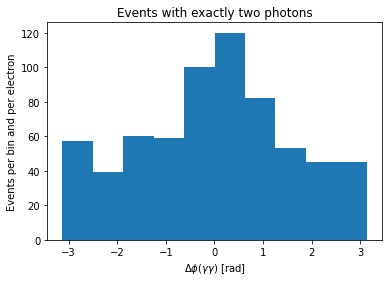

In [180]:
# Delta-phi(y,y)
plot_histo(df_yy_kinematics, 'delta_phi', 
           weight      = df_yy_kinematics['weight']/(BX*1.5e9),
           bins        = 10,
           title       = "Events with exactly two photons", 
           x_label     = r"$\Delta \phi (\gamma \gamma)$ [rad]", 
           y_label     = "Events per bin and per electron",
           file_name   = "delta_phi_yy",
           folder_name = output_folder)

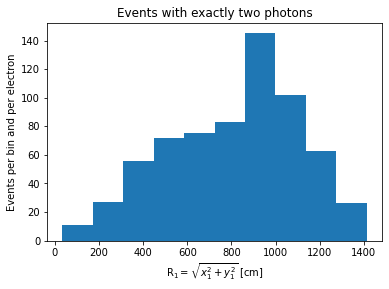

In [181]:
# r_1: distance of first photon from the center of the detector
plot_histo(df_yy_kinematics, 'r_1', 
           weight    = df_yy_kinematics['weight']/(BX*1.5e9),
           bins        = 10,
           title     = "Events with exactly two photons", 
           x_label   = "R$_1 = \sqrt{x_1^2 + y_1^2}$ [cm]", 
           y_label   = "Events per bin and per electron",
           file_name = "r_1_yy",
           folder_name = output_folder)

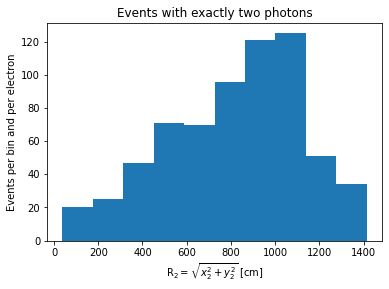

In [182]:
# r_2: distance of second photon from the center of the detector
plot_histo(df_yy_kinematics, 'r_2', 
           weight      = df_yy_kinematics['weight']/(BX*1.5e9), 
           bins        = 10,
           title       = "Events with exactly two photons", 
           x_label     = "R$_2 = \sqrt{x_2^2 + y_2^2}$ [cm]", 
           y_label     = "Events per bin and per electron",
           file_name   = "r_2_yy",
           folder_name = output_folder)

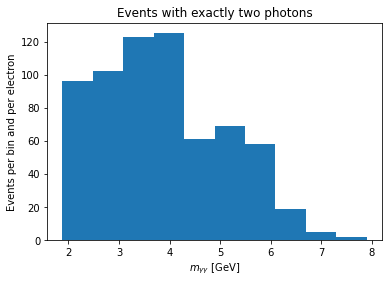

In [183]:
# m_yy: invariant mass of the two photons system
plot_histo(df_yy_kinematics, 'm_yy', 
           weight      = df_yy_kinematics['weight']/(BX*1.5e9),
           bins        = 10,
           title       = "Events with exactly two photons", 
           x_label     = "$m_{\gamma \gamma}$ [GeV]",
           y_label     = "Events per bin and per electron",
           file_name   = "m_yy",
           folder_name = output_folder)

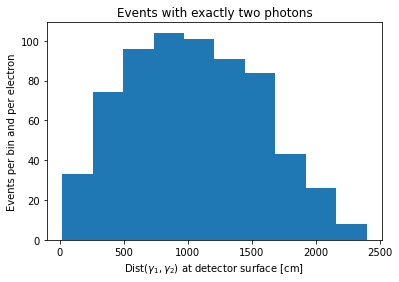

In [184]:
# dist_n1_n2: distance between the two photons at the detector surface
plot_histo(df_yy_kinematics, 'dist_n1_n2', 
           weight      = df_yy_kinematics['weight']/(BX*1.5e9),
           bins        = 10,
           title       = "Events with exactly two photons", 
           x_label     = "Dist($\gamma_1,\gamma_2$) at detector surface [cm]",
           y_label     = "Events per bin and per electron",
           file_name   = "dist_y1_y2",
           folder_name = output_folder)

### Case one photon and one neutron

Finally, we look at events with one photon and one neutron. We will use functions and definitions introduced in the previous cases.

In [185]:
# Select events with photons or neutrons
def is_photon(df_bsm):
    """Returns number of photons in each event"""
    return sum(df_bsm['pdg'] == 22)

def is_neutron(df_bsm):
    """Returns number of neutrons in each event"""
    return sum(df_bsm['pdg'] == 2112)

# We create a pandas series on the 'entry' index. It is a boolean series telling if each event has AT LEAST one photon
list_one_y = df_bsm.groupby('entry').apply(is_photon) > 0

# We create a pandas series on the 'entry' index. It is a boolean series telling if each event has AT LEAST one neutron
list_one_n = df_bsm.groupby('entry').apply(is_neutron) > 0

In [186]:
print(list_one_y[0:10])
print(list_one_n[0:10])

entry
3      False
4      False
71     False
84     False
205    False
206    False
225    False
236    False
243    False
271    False
dtype: bool
entry
3       True
4       True
71      True
84      True
205    False
206    False
225     True
236     True
243     True
271    False
dtype: bool


In [187]:
# Now create an AND of the two pandas series and convert them into a single 'mask' that we use to filter the dataframe
list_yn = list_one_y & list_one_n
print(list_yn[0:10])

mask_yn = list_yn[list_yn==True].index # At least one neutron and one photon in the event

entry
3      False
4      False
71     False
84     False
205    False
206    False
225    False
236    False
243    False
271    False
dtype: bool


In [188]:
# Here we filter
df_bsm_yn = df_bsm.loc[mask_yn]
df_bsm_yn.head(15)

E   pdg  detid  weight     theta       phi  \
entry subentry                                                          
368   7         3.572961e-08  2112   9000  1500.0  1.251556 -2.533612   
      8         2.321882e-04    22   9000  1500.0  0.524575 -0.488965   
1263  9         4.104287e-10  2112   9000  1500.0  0.854565 -2.296775   
      12        4.630885e-05    22   9000  1500.0  2.885890 -3.048631   
1995  7         4.223257e-10  2112   9000  1500.0  1.784918  1.115106   
      8         1.833854e-04    22   9000  1500.0  2.048993 -1.088048   
2051  7         1.160224e-08  2112   9000  1500.0  0.214209 -2.897164   
      8         4.180704e-04    12   9000  1500.0  2.392712 -2.143068   
      12        8.929646e-12  2112   9000  1500.0  0.530203  0.041458   
      13        5.109989e-04    22   9000  1500.0  0.895419  1.355936   
2925  11        1.251284e-03    22   9000  1500.0  0.440006  1.024484   
      12        8.635927e-06  2112   9000  1500.0  0.237710 -0.931507   
5131  11        3.715960e-07  2112   9000  1500.0  2.061637 -0.206468   
      17        3.324222e-08  2112   9000  1500.0  0.321238 -1.278460   
      20        4.933997e-03    22   9000  1500.0  0.718025 -1.692277   

                       vtxx         vtxy          vtxz        px  \
entry subentry                                                     
368   7         -140.474307    26.383800   7309.566450 -0.000202   
      8        -1587.336596  -130.311793  12788.755815  0.000103   
1263  9         -109.049712  -563.226244  11277.011821 -0.000014   
      12        -514.647407  1911.103262  16623.706782 -0.000012   
1995  7         -168.428903  -117.437625   7128.249890  0.000012   
      8           29.718465  -890.733586  16175.228301  0.000076   
2051  7         -124.509289     0.170595   7307.254708 -0.000030   
      8          278.357822  2062.727657  17938.133135 -0.000154   
      12         -90.698525    61.551155   7289.195377  0.000002   
      13        -128.964654    38.616957  15722.327104  0.000085   
2925  11       -2957.020756 -2782.028699   7525.003489  0.000277   
      12        -237.084147    81.487014   7383.038318  0.000566   
5131  11        -180.580973   -16.902046   7398.510418  0.000721   
      17        -301.418184    43.572156   7722.587935  0.000023   
      20          47.212246  1969.418933  13553.367436 -0.000393   

                          py        pz            x           y             z  
entry subentry                                                                 
368   7        -1.405312e-04  0.000081  -312.870856 -781.512955  16000.000000  
      8        -5.462304e-05  0.000201   156.792612 -961.619356  16000.000000  
1263  9        -1.566562e-05  0.000018  -105.434342  146.937494  16000.000000  
      12       -1.087264e-06 -0.000045  -207.012999   27.141220  16178.060000  
1995  7         2.471867e-05 -0.000006    27.521057 -896.262464  16178.060000  
      8        -1.442084e-04 -0.000084  -341.669742  825.619633  16178.060000  
2051  7        -7.595934e-06  0.000144    27.527511  768.863292  16000.000000  
      8        -2.392812e-04 -0.000306  -607.607717  687.384447  16178.060000  
      12        8.585823e-08  0.000004  -149.934729  107.623732  16000.000000  
      13        3.896493e-04  0.000319   -55.057439  377.284742  16000.000000  
2925  11        4.554008e-04  0.001132 -1002.500000  868.428762  16107.082892  
      12       -7.612728e-04  0.003915  -836.617288  424.048344  16000.000000  
5131  11       -1.510828e-04 -0.000394   -71.060004  772.348368  16178.060000  
      17       -7.556615e-05  0.000237   575.513890 -485.817954  16000.000000  
      20       -3.222147e-03  0.003716  -211.794218 -152.158159  16000.000000

As we did in the previous cases, we order, in each event, the particles by their energy, and keep events in which the two most energetic particles are one neutron and one photon.

In [189]:
# Sort by particle Energy
df_bsm_yn_sort = df_bsm_yn.groupby('entry').apply(lambda x: x.sort_values(['E'], ascending=False))
df_bsm_yn_sort.head(20)

E   pdg  detid  weight     theta       phi  \
entry entry subentry                                                          
368   368   8         2.321882e-04    22   9000  1500.0  0.524575 -0.488965   
            7         3.572961e-08  2112   9000  1500.0  1.251556 -2.533612   
1263  1263  12        4.630885e-05    22   9000  1500.0  2.885890 -3.048631   
            9         4.104287e-10  2112   9000  1500.0  0.854565 -2.296775   
1995  1995  8         1.833854e-04    22   9000  1500.0  2.048993 -1.088048   
            7         4.223257e-10  2112   9000  1500.0  1.784918  1.115106   
2051  2051  13        5.109989e-04    22   9000  1500.0  0.895419  1.355936   
            8         4.180704e-04    12   9000  1500.0  2.392712 -2.143068   
            7         1.160224e-08  2112   9000  1500.0  0.214209 -2.897164   
            12        8.929646e-12  2112   9000  1500.0  0.530203  0.041458   
2925  2925  11        1.251284e-03    22   9000  1500.0  0.440006  1.024484   
            12        8.635927e-06  2112   9000  1500.0  0.237710 -0.931507   
5131  5131  20        4.933997e-03    22   9000  1500.0  0.718025 -1.692277   
            36        1.900859e-03    22   9000  1500.0  0.260258  1.466448   
            11        3.715960e-07  2112   9000  1500.0  2.061637 -0.206468   
            17        3.324222e-08  2112   9000  1500.0  0.321238 -1.278460   
            21        1.475016e-10  2112   9000  1500.0  0.494611  1.573943   
            40        6.392952e-11  2112   9000  1500.0  2.700959  1.916259   
5151  5151  8         1.069008e-03    12   9000  1500.0  0.137688  0.667447   
            14        1.834667e-04    22   9000  1500.0  0.213966 -2.892870   

                             vtxx         vtxy          vtxz            px  \
entry entry subentry                                                         
368   368   8        -1587.336596  -130.311793  12788.755815  1.026634e-04   
            7         -140.474307    26.383800   7309.566450 -2.019364e-04   
1263  1263  12        -514.647407  1911.103262  16623.706782 -1.166208e-05   
            9         -109.049712  -563.226244  11277.011821 -1.390641e-05   
1995  1995  8           29.718465  -890.733586  16175.228301  7.558086e-05   
            7         -168.428903  -117.437625   7128.249890  1.211444e-05   
2051  2051  13        -128.964654    38.616957  15722.327104  8.503288e-05   
            8          278.357822  2062.727657  17938.133135 -1.541396e-04   
            7         -124.509289     0.170595   7307.254708 -3.045487e-05   
            12         -90.698525    61.551155   7289.195377  2.069774e-06   
2925  2925  11       -2957.020756 -2782.028699   7525.003489  2.769028e-04   
            12        -237.084147    81.487014   7383.038318  5.659608e-04   
5131  5131  20          47.212246  1969.418933  13553.367436 -3.933663e-04   
            36         253.115394   157.475948  13927.876651  5.094900e-05   
            11        -180.580973   -16.902046   7398.510418  7.213206e-04   
            17        -301.418184    43.572156   7722.587935  2.274229e-05   
            21         -46.341625  -116.282011   7480.421654 -2.486800e-08   
            40         152.766647   -50.290576   7264.966099 -1.583029e-06   
5151  5151  8          -20.677166    89.278745   7478.894160  1.152384e-04   
            14        1854.552318   831.762104  10188.684177 -3.775799e-05   

                                py        pz            x           y  \
entry entry subentry                                                    
368   368   8        -5.462304e-05  0.000201   156.792612 -961.619356   
            7        -1.405312e-04  0.000081  -312.870856 -781.512955   
1263  1263  12       -1.087264e-06 -0.000045  -207.012999   27.141220   
            9        -1.566562e-05  0.000018  -105.434342  146.937494   
1995  1995  8        -1.442084e-04 -0.000084  -341.669742  825.619633   
            7         2.471867e-05 -0.000006    27.521057 -896.262

In [190]:
# First case: most energetic particle is a photon and second most energetic particle is a neutron
yn_mask = (df_bsm_yn_sort.groupby('entry').nth(0)['pdg'] == 22) & (df_bsm_yn_sort.groupby('entry').nth(1)['pdg'] == 2112) 
print(yn_mask[:10])

# Second case: most energetic particle is a neutron and second most energetic particle is a photon
ny_mask = (df_bsm_yn_sort.groupby('entry').nth(0)['pdg'] == 2112) & (df_bsm_yn_sort.groupby('entry').nth(1)['pdg'] == 22)
print(ny_mask[:10])

entry
368      True
1263     True
1995     True
2051    False
2925     True
5131    False
5151    False
6251     True
6254    False
6592     True
Name: pdg, dtype: bool
entry
368     False
1263    False
1995    False
2051    False
2925    False
5131    False
5151    False
6251    False
6254    False
6592    False
Name: pdg, dtype: bool


In [191]:
# Final mask: OR of the two previous cases
yn_or_ny_mask = yn_mask | ny_mask
print(yn_or_ny_mask[:10])

entry
368      True
1263     True
1995     True
2051    False
2925     True
5131    False
5151    False
6251     True
6254    False
6592     True
Name: pdg, dtype: bool


In [192]:
# Create the actual mask - maybe not the clearest names :(
mask_yn_or_ny = yn_or_ny_mask[yn_or_ny_mask==True].index

In [193]:
# Apply the mask
df_bsm_yn_or_ny = df_bsm_yn_sort.loc[mask_yn_or_ny]
df_bsm_yn_or_ny.head(10)

E   pdg  detid  weight     theta       phi  \
entry entry subentry                                                          
368   368   8         2.321882e-04    22   9000  1500.0  0.524575 -0.488965   
            7         3.572961e-08  2112   9000  1500.0  1.251556 -2.533612   
1263  1263  12        4.630885e-05    22   9000  1500.0  2.885890 -3.048631   
            9         4.104287e-10  2112   9000  1500.0  0.854565 -2.296775   
1995  1995  8         1.833854e-04    22   9000  1500.0  2.048993 -1.088048   
            7         4.223257e-10  2112   9000  1500.0  1.784918  1.115106   
2925  2925  11        1.251284e-03    22   9000  1500.0  0.440006  1.024484   
            12        8.635927e-06  2112   9000  1500.0  0.237710 -0.931507   
6251  6251  8         3.473139e-03    22   9000  1500.0  0.700099 -0.196570   
            7         1.905351e-07  2112   9000  1500.0  0.650555 -0.915740   

                             vtxx         vtxy          vtxz        px  \
entry entry subentry                                                     
368   368   8        -1587.336596  -130.311793  12788.755815  0.000103   
            7         -140.474307    26.383800   7309.566450 -0.000202   
1263  1263  12        -514.647407  1911.103262  16623.706782 -0.000012   
            9         -109.049712  -563.226244  11277.011821 -0.000014   
1995  1995  8           29.718465  -890.733586  16175.228301  0.000076   
            7         -168.428903  -117.437625   7128.249890  0.000012   
2925  2925  11       -2957.020756 -2782.028699   7525.003489  0.000277   
            12        -237.084147    81.487014   7383.038318  0.000566   
6251  6251  8        -3713.193849  1304.065275  11132.122492  0.002195   
            7         -123.212943    -0.112097   7324.429440  0.000221   

                            py        pz            x           y  \
entry entry subentry                                                
368   368   8        -0.000055  0.000201   156.792612 -961.619356   
            7        -0.000141  0.000081  -312.870856 -781.512955   
1263  1263  12       -0.000001 -0.000045  -207.012999   27.141220   
            9        -0.000016  0.000018  -105.434342  146.937494   
1995  1995  8        -0.000144 -0.000084  -341.669742  825.619633   
            7         0.000025 -0.000006    27.521057 -896.262464   
2925  2925  11        0.000455  0.001132 -1002.500000  868.428762   
            12       -0.000761  0.003915  -836.617288  424.048344   
6251  6251  8        -0.000437  0.002656   306.263644  504.957092   
            7        -0.000287  0.000476  -271.616788 -476.654483   

                                 z  
entry entry subentry                
368   368   8         16000.000000  
            7         16000.000000  
1263  1263  12        16178.060000  
            9         16000.000000  
1995  1995  8         16178.060000  
            7         16178.060000  
2925  2925  11        16107.082892  
            12        16000.000000  
6251  6251  8         16000.000000  
            7         16000.000000

Now we build some interesting kinematic variables, per event.

In [194]:
df_yn_or_ny_kinematics = pd.DataFrame()

In [195]:
# Delta phi 
def delta_phi(df_yn_or_ny_kinematics):
    d_phi = df_yn_or_ny_kinematics['phi_1'] - df_yn_or_ny_kinematics['phi_2']    
    if d_phi >= np.pi: d_phi = d_phi - 2*np.pi
    if d_phi < -np.pi: d_phi = d_phi + 2*np.pi
    return d_phi
    

# Copying TLorentzVector definition https://root.cern.ch/doc/master/TLorentzVector_8h_source.html#l00498
def inv_mass(E_1, px_1, py_1, pz_1,
             E_2, px_2, py_2, pz_2):
    return np.sqrt( np.absolute((E_1+E_2)**2 - (px_1+px_2)**2 - (py_1+py_2)**2 - (pz_1+pz_2)**2) )

In [196]:
# Dirty trick to have the first and second particles: create two separate dataframes
# with the first and second subentry
df_bsm_yn_or_ny_first  = df_bsm_yn_or_ny.groupby('entry').nth(0)
df_bsm_yn_or_ny_second = df_bsm_yn_or_ny.groupby('entry').nth(1)

In [197]:
# Event variables
df_yn_or_ny_kinematics["weight"] = df_bsm_yn_or_ny_first["weight"]

# Build first particle
df_yn_or_ny_kinematics["E_1"] = df_bsm_yn_or_ny_first["E"]
df_yn_or_ny_kinematics["m_1"] = 0.939565
df_yn_or_ny_kinematics["eta_1"] = -np.log(np.tan(0.5*df_bsm_yn_or_ny_first["theta"]))
df_yn_or_ny_kinematics["theta_1"] = df_bsm_yn_or_ny_first["theta"]
df_yn_or_ny_kinematics["phi_1"] = df_bsm_yn_or_ny_first["phi"]
df_yn_or_ny_kinematics["vtxx_1"] = df_bsm_yn_or_ny_first["vtxx"]
df_yn_or_ny_kinematics["vtxy_1"] = df_bsm_yn_or_ny_first["vtxy"]
df_yn_or_ny_kinematics["vtxz_1"] = df_bsm_yn_or_ny_first["vtxz"]
df_yn_or_ny_kinematics["px_1"] = df_bsm_yn_or_ny_first["px"]
df_yn_or_ny_kinematics["py_1"] = df_bsm_yn_or_ny_first["py"]
df_yn_or_ny_kinematics["pz_1"] = df_bsm_yn_or_ny_first["pz"]
df_yn_or_ny_kinematics["x_1"] = df_bsm_yn_or_ny_first["x"]
df_yn_or_ny_kinematics["y_1"] = df_bsm_yn_or_ny_first["y"]
df_yn_or_ny_kinematics["z_1"] = df_bsm_yn_or_ny_first["z"]

# Build second particle
df_yn_or_ny_kinematics["E_2"] = df_bsm_yn_or_ny_second["E"]
df_yn_or_ny_kinematics["m_2"] = 0.939565
df_yn_or_ny_kinematics["eta_2"] = -np.log(np.tan(0.5*df_bsm_yn_or_ny_second["theta"]))
df_yn_or_ny_kinematics["theta_2"] = df_bsm_yn_or_ny_second["theta"]
df_yn_or_ny_kinematics["phi_2"] = df_bsm_yn_or_ny_second["phi"]
df_yn_or_ny_kinematics["vtxx_2"] = df_bsm_yn_or_ny_second["vtxx"]
df_yn_or_ny_kinematics["vtxy_2"] = df_bsm_yn_or_ny_second["vtxy"]
df_yn_or_ny_kinematics["vtxz_2"] = df_bsm_yn_or_ny_second["vtxz"]
df_yn_or_ny_kinematics["px_2"] = df_bsm_yn_or_ny_second["px"]
df_yn_or_ny_kinematics["py_2"] = df_bsm_yn_or_ny_second["py"]
df_yn_or_ny_kinematics["pz_2"] = df_bsm_yn_or_ny_second["pz"]
df_yn_or_ny_kinematics["x_2"] = df_bsm_yn_or_ny_second["x"]
df_yn_or_ny_kinematics["y_2"] = df_bsm_yn_or_ny_second["y"]
df_yn_or_ny_kinematics["z_2"] = df_bsm_yn_or_ny_second["z"]

In [198]:
df_yn_or_ny_kinematics["m_yn"] = inv_mass(df_yn_or_ny_kinematics["E_1"], df_yn_or_ny_kinematics["m_1"], df_yn_or_ny_kinematics["eta_1"], df_yn_or_ny_kinematics["phi_1"],
                                          df_yn_or_ny_kinematics["E_2"], df_yn_or_ny_kinematics["m_2"], df_yn_or_ny_kinematics["eta_2"], df_yn_or_ny_kinematics["phi_2"])

In [199]:
# particle distance from the center of the detector
df_yn_or_ny_kinematics["r_1"] = np.sqrt(df_yn_or_ny_kinematics["x_1"]**2 + df_yn_or_ny_kinematics["y_1"]**2)
df_yn_or_ny_kinematics["r_2"] = np.sqrt(df_yn_or_ny_kinematics["x_2"]**2 + df_yn_or_ny_kinematics["y_2"]**2)

# Distance between the two particles at the detector surface
df_yn_or_ny_kinematics["dist_yn"] = np.sqrt( (df_yn_or_ny_kinematics["x_2"] - df_yn_or_ny_kinematics["x_1"])**2 + (df_yn_or_ny_kinematics["y_1"] - df_yn_or_ny_kinematics["y_2"])**2)

In [201]:
# Delta_phi between photons
df_yn_or_ny_kinematics["delta_phi"] = df_yn_or_ny_kinematics.apply(delta_phi, axis = 1)
df_yn_or_ny_kinematics[['E_1','E_2','phi_1','phi_2','delta_phi']].head(10)

,E_1,E_2,phi_1,phi_2,delta_phi
entry,,,,,
368,0.000232,3.572961e-08,-0.488965,-2.533612,2.044646
1263,0.000046,4.104287e-10,-3.048631,-2.296775,-0.751855
1995,0.000183,4.223257e-10,-1.088048,1.115106,-2.203154
2925,0.001251,8.635927e-06,1.024484,-0.931507,1.955991
6251,0.003473,1.905351e-07,-0.196570,-0.915740,0.719170
6592,0.000146,3.319224e-11,-0.019252,0.868715,-0.887967
6593,0.000246,6.271272e-07,0.708346,0.898149,-0.189802
7124,0.000752,2.042261e-10,0.815235,-0.576541,1.391777
8255,0.000083,1.041815e-11,-3.004702,0.502100,2.776383


In [202]:
# Having a look at the dataframe
df_yn_or_ny_kinematics.head(5)

,weight,E_1,m_1,eta_1,theta_1,phi_1,vtxx_1,vtxy_1,vtxz_1,px_1,...,py_2,pz_2,x_2,y_2,z_2,m_yn,r_1,r_2,dist_yn,delta_phi
entry,,,,,,,,,,,,,,,,,,,,,
368,1500.0,0.000232,0.939565,1.315007,0.524575,-0.488965,-1587.336596,-130.311793,12788.755815,0.000103,...,-0.000141,0.000081,-312.870856,-781.512955,16000.00,3.918684,974.318074,841.813917,503.013011,2.044646
1263,1500.0,0.000046,0.939565,-2.051420,2.885890,-3.048631,-514.647407,1911.103262,16623.706782,-0.000012,...,-0.000016,0.000018,-105.434342,146.937494,16000.00,5.805512,208.784644,180.850843,157.064862,-0.751855
1995,1500.0,0.000183,0.939565,-0.497538,2.048993,-1.088048,29.718465,-890.733586,16175.228301,0.000076,...,0.000025,-0.000006,27.521057,-896.262464,16178.06,2.010144,893.524477,896.684901,1761.016695,-2.203154
2925,1500.0,0.001251,0.939565,1.497797,0.440006,1.024484,-2957.020756,-2782.028699,7525.003489,0.000277,...,-0.000761,0.003915,-836.617288,424.048344,16000.00,4.082319,1326.338857,937.947485,474.332193,1.955991
6251,1500.0,0.003473,0.939565,1.007626,0.700099,-0.196570,-3713.193849,1304.065275,11132.122492,0.002195,...,-0.000287,0.000476,-271.616788,-476.654483,16000.00,3.025794,590.575215,548.612045,1139.081682,0.719170


Now, finally plotting. We define again a function for that - the same we defined for neutrons - and we plot some distributions.

In [129]:
import matplotlib.pyplot as plt
import sys,os

def plot_histo(df, variable, weight=1, bins=10, title="", x_label="", y_label="", file_name=None, folder_name=None, file_format="png"):
    """Plots distributions from a dataframe

    df: input dataframe
    variable: distribution to plot
    title: appears on top of the plot
    weight: weight to apply to the histogram
    x_label: label of x-axis
    y_label: label of y-axis
    file_name: if not empty, name of file where plot is printed
    folder_name: if not empty, name of directory where plot is printed
    file_format: if file_name not empty, format of output file
    """

    # Prepare histogram
    # df[variable].plot(kind='hist', weights=weight)
    plt.hist(df[variable], bins=bins)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Preparing output
    if file_name:
        output_name = file_name + "." + file_format
        if folder_name:
            command = "mkdir -p {}".format(folder_name)
            os.system(command)
            output_name = folder_name + "/" + file_name + "." + file_format
        plt.savefig(output_name)

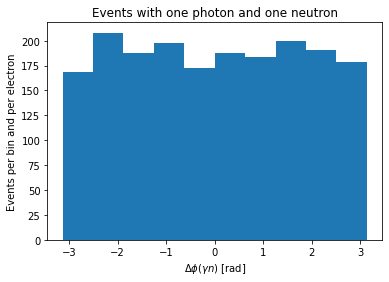

In [130]:
# Delta-phi(y,n)
plot_histo(df_yn_or_ny_kinematics, 'delta_phi', 
           weight      = df_yn_or_ny_kinematics['weight']/(BX*1.5e9),
           bins        = 10,
           title       = "Events with one photon and one neutron", 
           x_label     = r"$\Delta \phi (\gamma n)$ [rad]", 
           y_label     = "Events per bin and per electron",
           file_name   = "delta_phi_yn",
           folder_name = output_folder)

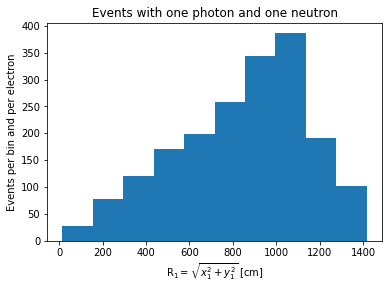

In [131]:
# r_1: distance of first particle from the center of the detector
plot_histo(df_yn_or_ny_kinematics, 'r_1', 
           weight      = df_yn_or_ny_kinematics['weight']/(BX*1.5e9),
           bins        = 10,
           title       = "Events with one photon and one neutron", 
           x_label     = "R$_1 = \sqrt{x_1^2 + y_1^2}$ [cm]", 
           y_label     = "Events per bin and per electron",
           file_name   = "r_1_yn",
           folder_name = output_folder)

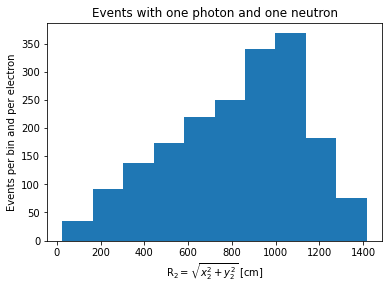

In [132]:
# r_2: distance of second particle from the center of the detector
plot_histo(df_yn_or_ny_kinematics, 'r_2', 
           weight      = df_yn_or_ny_kinematics['weight']/(BX*1.5e9), 
           bins        = 10,
           title       = "Events with one photon and one neutron", 
           x_label     = "R$_2 = \sqrt{x_2^2 + y_2^2}$ [cm]", 
           y_label     = "Events per bin and per electron",
           file_name   = "r_2_yn",
           folder_name = output_folder)

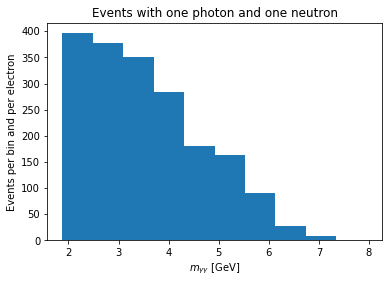

In [133]:
# m_yn: invariant mass of the two particles system
plot_histo(df_yn_or_ny_kinematics, 'm_yn', 
           weight      = df_yn_or_ny_kinematics['weight']/(BX*1.5e9), 
           bins        = 10,
           title       = "Events with one photon and one neutron", 
           x_label     = "$m_{\gamma \gamma}$ [GeV]",
           y_label     = "Events per bin and per electron",
           file_name   = "m_yn",
           folder_name = output_folder)

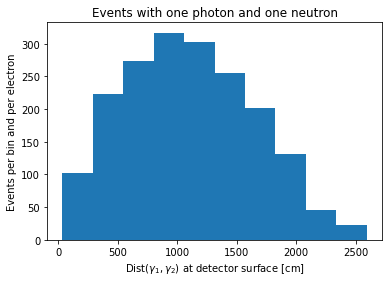

In [134]:
# dist_yn: distance between the two particles at the detector surface
plot_histo(df_yn_or_ny_kinematics, 'dist_yn', 
           weight      = df_yn_or_ny_kinematics['weight']/(BX*1.5e9), 
           bins        = 10,
           title       = "Events with one photon and one neutron", 
           x_label     = "Dist($\gamma_1,\gamma_2$) at detector surface [cm]",
           y_label     = "Events per bin and per electron",
           file_name   = "dist_yn",
           folder_name = output_folder)

# Additional stuff or tests

In [135]:
df_nn_kinematics['delta_phi'].plot(kind="hist", weights=df['weight']/(1.5e9))
plt.title("Events with exactly two neutrons")
plt.xlabel(r"$\Delta \phi$ [rad]")
plt.ylabel("Events per bin")

NameError: name 'df' is not defined

<AxesSubplot:ylabel='Frequency'>

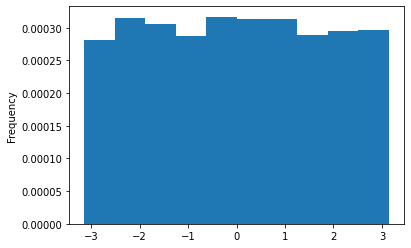

In [ ]:
df_nn_kinematics['delta_phi'].plot(kind="hist", weights=df_nn_kinematics['weight']/(1.5e9))

In [ ]:
# reference example
def get_sum_E(df_bsm_nn):
    return sum(df_bsm_nn['E'])

df_nn_kinematics = pd.DataFrame()

df_nn_kinematics['sum_E'] = df_bsm_nn.groupby('entry').apply(get_sum_E)


In [ ]:
df_nn_kinematics.head(10)